<center> <h1> <b>   Proyecto #1: Gaia</b> </h1>
<h2>Santiago Lastra Ramírez </h2> </center>
<br>
<center> <h2 style="color: #777; font-size: 15pt; font-style: oblique; "> Minería de Datos </h2>
<h2 style="color: #777; font-size: 15pt; font-style: oblique; "> Intituto de Física - Universidad de Antioquia </h2>  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit,root
from scipy.interpolate import CubicSpline
from astropy import units as u
from astropy.table import unique
from astroquery.xmatch import XMatch
import astropy.coordinates as coord
import pandas as pd
import math 

d = math.dist

%matplotlib nbagg

plt.style.use('classic')
plt.rcParams['text.usetex'] = True

Could not import regions, which is required for some of the functionalities of this module.


# 1. Crossmatch con el ED3.

A continuación se realiza el crossmatch entre el catálogo de miembros de Sco OB2 propuesto por Rizzuto et al. (2011) y el catálogo EDR3 de Gaia obtenidos a través de VizieR. Vale aclarar que el query requiere de conexión a internet para funcionar.

In [ ]:
table = XMatch.query(cat1='vizier:J/MNRAS/416/3108/tablea1',
                     cat2='vizier:I/350/gaiaedr3',
                     max_distance=1*u.arcsec, colRA1='_RA',
                     colDec1='_DE')

match = unique(table, keys=['HIP']).to_pandas()

# 2. Limpieza

En los gráficos a continuación se verán histogramas de los parámetros que serán de importancia en este trabajo, los cuales permitirán realizar una limpieza preliminar de outliers y datos nulos.

<IPython.core.display.Javascript object>


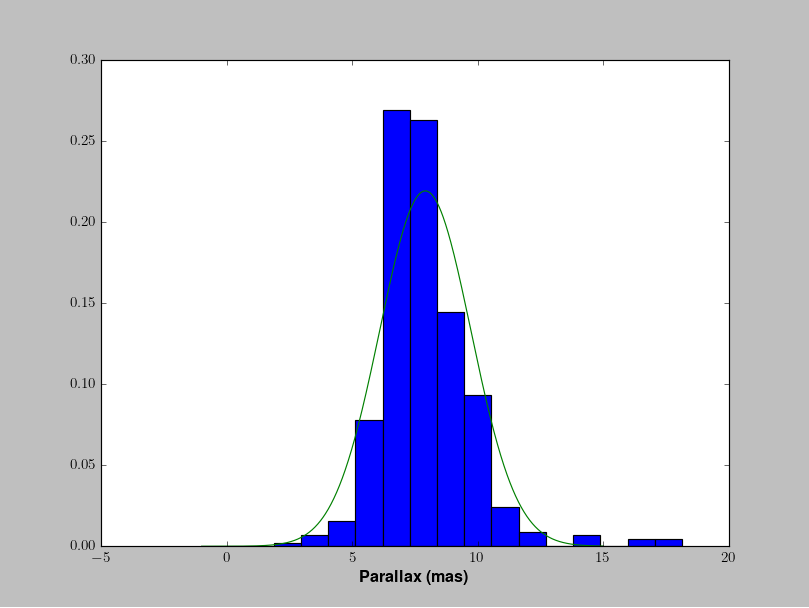

2.45437517358656 13.368256227379625


In [ ]:
μ_plx, σ_plx = norm.fit(match['parallax'].dropna())

x_plx = np.linspace(-1,15,1000)

plt.figure(dpi=70)
plt.hist(match['parallax'], bins = 'rice', edgecolor='k', density=1)
plt.plot(x_plx, norm.pdf(x_plx,μ_plx, σ_plx))
plt.xlabel(r'\textbf{Parallax (mas)}',fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

print(μ_plx - 3*σ_plx,μ_plx + 3*σ_plx)

<IPython.core.display.Javascript object>


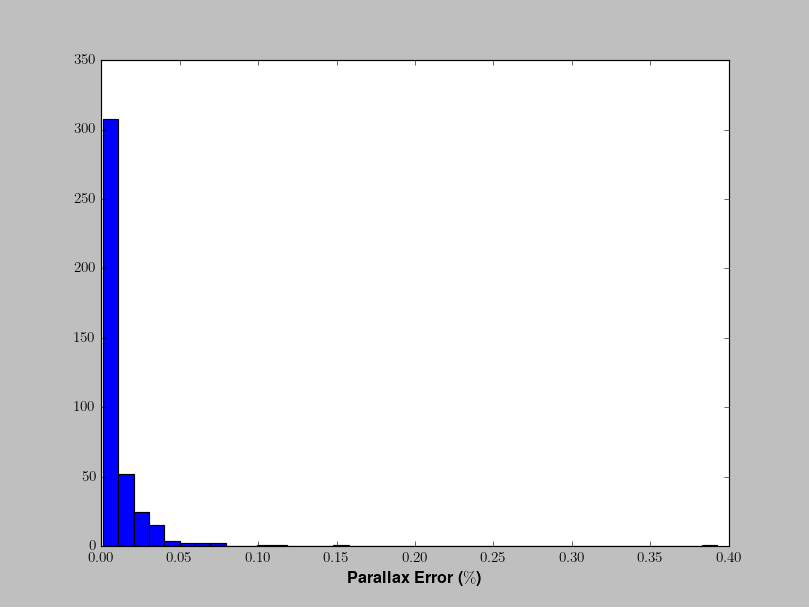

In [ ]:
plt.figure(dpi=70)
plt.hist(match['parallax_error']/match['parallax'], bins = 40, edgecolor='k')
plt.xlabel(r'\textbf{Parallax Error ($\%$)}',fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

<IPython.core.display.Javascript object>


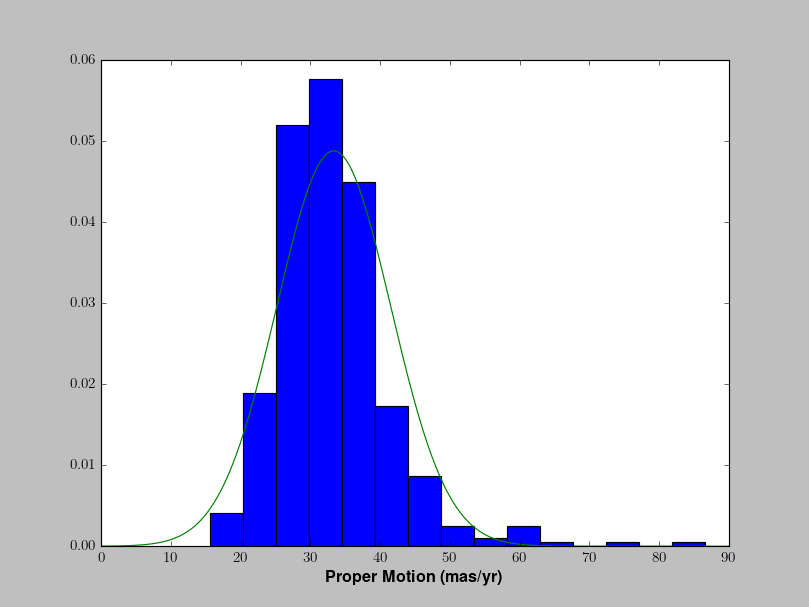

8.82924634927883 57.87347345748445


In [ ]:
μ_pm, σ_pm = norm.fit(match['pm'].dropna())

x_pm = np.linspace(0,90,1000)

plt.figure(dpi=70)
plt.hist(match['pm'], bins = 'rice', edgecolor='k', density=1)
plt.plot(x_pm, norm.pdf(x_pm,μ_pm, σ_pm))
plt.xlabel(r'\textbf{Proper Motion (mas/yr)}',fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

print(μ_pm - 3*σ_pm,μ_pm + 3*σ_pm)

<IPython.core.display.Javascript object>


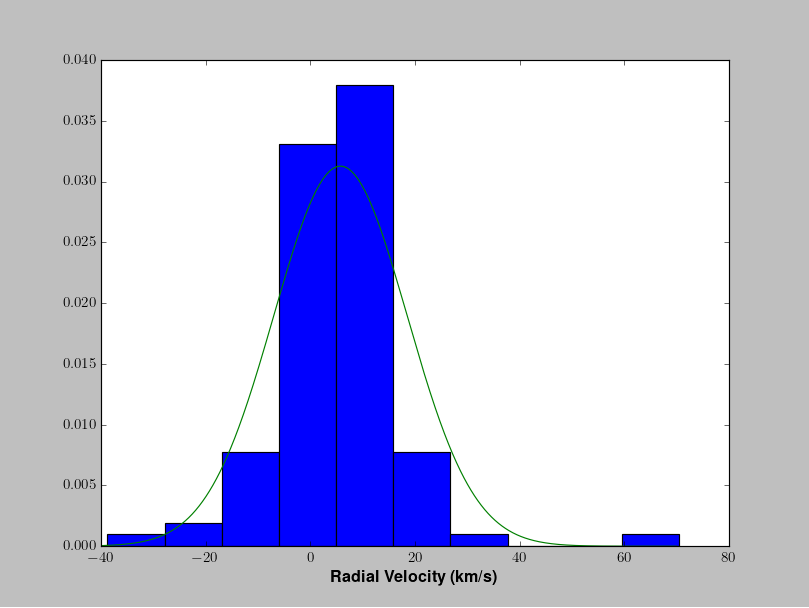

-32.51288841094606 44.01225011307372


In [ ]:
μ_rv, σ_rv = norm.fit(match['dr2_radial_velocity'].dropna())

x_rv = np.linspace(-40,70,1000)

plt.figure(dpi=70)
plt.hist(match['dr2_radial_velocity'], bins = 'rice', edgecolor='k', density=1)
plt.plot(x_rv, norm.pdf(x_rv,μ_rv, σ_rv))
plt.xlabel(r'\textbf{Radial Velocity (km/s)}',fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

print(μ_rv - 3*σ_rv,μ_rv + 3*σ_rv)

Eliminamos las filas con valores `NaN` y aplicamos los filtros de paralaje, movimiento propio y velocidad radial:

In [ ]:
match = match[(match['parallax']<13)&(match['pm']<58)&(match['dr2_radial_velocity']<44)&(match['parallax_over_error']>10)].reset_index()

match_clean = match.dropna(subset = ['parallax','pmra','pmdec','dr2_radial_velocity']).reset_index()

match_clean

,level_0,index,angDist,_RAJ2000,_DEJ2000,HIP,Memb,Simbad,_RA,_DE,...,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000_error,dec_epoch2000_error,ra_dec_epoch2000_corr
0,0,9,0.026192,169.969756,-70.618472,55334,58,Simbad,169.96976,-70.61847,...,0.002769,0.002827,0.003800,8.050057,0.002769,11348100.0,0.004,0.6269,0.5594,0.1805
1,1,13,0.009689,173.273234,-54.324594,56354,84,Simbad,173.27323,-54.32459,...,0.002774,0.002889,0.003825,7.735444,0.002774,15162400.0,0.010,0.3511,0.3764,0.3981
2,2,21,0.008642,178.283373,-56.727251,57950,76,Simbad,178.28337,-56.72725,...,0.002765,0.002823,0.003809,8.159342,0.002765,10261500.0,0.003,0.2752,0.2836,0.3268
3,3,23,0.007085,178.931449,-54.180689,58167,87,Simbad,178.93145,-54.18069,...,0.002764,0.002820,0.003791,8.188871,0.002764,9986150.0,0.003,0.2921,0.3013,0.4198
4,4,24,0.011388,179.110677,-58.821342,58220,88,Simbad,179.11068,-58.82134,...,0.002763,0.002837,0.003790,8.391838,0.002763,8283460.0,0.006,0.2709,0.3144,0.3983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,420,0.017674,251.947241,-19.875539,82218,89,Simbad,251.94724,-19.87554,...,0.002762,0.002802,0.003791,8.924353,0.002762,5072310.0,0.004,0.3221,0.2184,0.0810
87,87,421,0.028731,252.300897,-22.711573,82319,51,Simbad,252.30090,-22.71157,...,0.002761,0.002813,0.003792,8.795698,0.002761,5710410.0,0.003,0.4086,0.2901,0.0239
88,88,425,0.014390,253.055472,-26.919674,82534,89,Simbad,253.05547,-26.91967,...,0.002768,0.002821,0.003794,8.215842,0.002768,9741140.0,0.003,0.5353,0.3597,0.2900
89,89,429,0.064818,253.173820,-38.760354,82569,63,Simbad,253.17382,-38.76035,...,0.002829,0.003060,0.003992,8.748213,0.002829,5965700.0,0.004,1.6320,1.2536,-0.1171


# 3. Solución Astrométrica.

Para calcular la solución astrométrica se usará el código proveido por el profesor Germán Chaparro en el cual se hace referido al sistema galactocéntrico:

In [ ]:
def astrosol(j):
    x=1000/j['parallax']*np.cos(j['dec']*np.pi/180)*np.cos(j['ra']*np.pi/180)
    y=1000/j['parallax']*np.cos(j['dec']*np.pi/180)*np.sin(j['ra']*np.pi/180)
    z=1000/j['parallax']*np.sin(j['dec']*np.pi/180)
    vx=[]
    vy=[]
    vz=[]
    xa=[]
    ya=[]
    za=[]
    for i in range(len(j)):
        mdec=j['dec'][i]
        mra=j['ra'][i]
        mpar=j['parallax'][i]
        mpmra=j['pmra'][i]
        mpmdec=j['pmdec'][i]
        mvr=j['dr2_radial_velocity'][i]
        c1 = coord.ICRS(ra=mra*u.degree, dec=mdec*u.degree,
                    distance=(mpar*u.mas).to(u.pc, u.parallax()),
                    pm_ra_cosdec=mpmra*u.mas/u.yr,
                    pm_dec=mpmdec*u.mas/u.yr,
                    radial_velocity=mvr*u.km/u.s)
        gc1 = c1.transform_to(coord.Galactocentric)
        vx+=[gc1.v_x.value]
        vy+=[gc1.v_y.value]
        vz+=[gc1.v_z.value]
        xa+=[gc1.x.value]
        ya+=[gc1.y.value]
        za+=[gc1.z.value]
    x=np.array(x)   #pc    
    y=np.array(y)   #pc    
    z=np.array(z)   #pc    
    xa=np.array(xa) #pc
    ya=np.array(ya) #pc
    za=np.array(za) #pc   
    vx=np.array(vx)*3.24078e-14/(3.17098e-8)  #pc/yr
    vy=np.array(vy)*3.24078e-14/(3.17098e-8)  #pc/yr
    vz=np.array(vz)*3.24078e-14/(3.17098e-8)  #pc/yr
    return x,y,z,vx,vy,vz,xa,ya,za

x,y,z,vx,vy,vz,xa,ya,za = astrosol(match_clean)

# 4. Cinemática del Grupo.

Definamos una función que calcule la posición del centro de masa en un instante particular en el tiempo:

In [ ]:
def rcm(x0,y0,z0,vx,vy,vz,t):
    
    N = len(x0)
    
    x = x0 - vx*t 
    y = y0 - vy*t
    z = z0 - vz*t
    
    x_cm = x.sum()/N
    y_cm = y.sum()/N
    z_cm = z.sum()/N
    
    return(x_cm,y_cm,z_cm)

Ahora, grafiquemos las posiciones de las estrellas en los planos $YZ$ y $XY$ en tres instantes diferentes de tiempo junto con sus respectivos centros de masa suponiendo trayectorias rectilíneas:

<IPython.core.display.Javascript object>


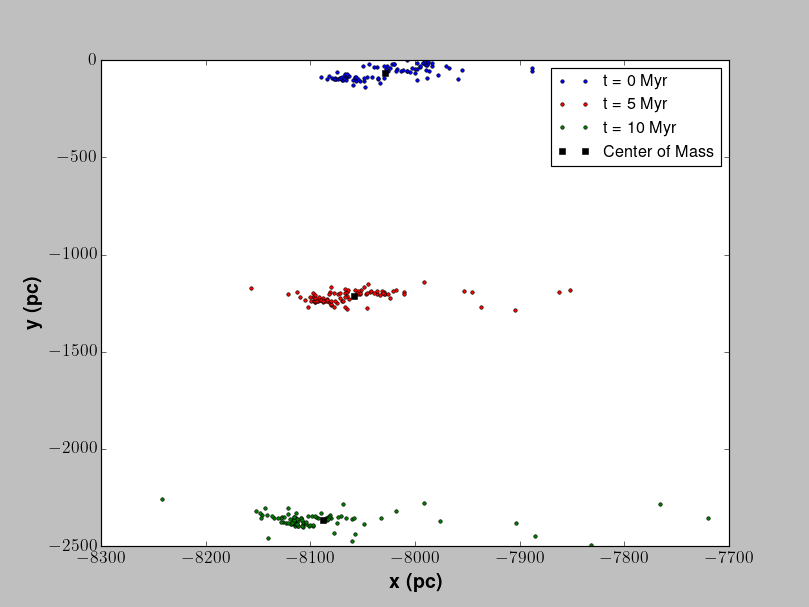

In [ ]:
t = np.linspace(0,10e6,2)

t1 = 0
t2 = 5e6
t3 = 10e6

xcm1,ycm1,zcm1 = rcm(xa,ya,za,vx,vy,vz,t1)
xcm2,ycm2,zcm2 = rcm(xa,ya,za,vx,vy,vz,t2)
xcm3,ycm3,zcm3 = rcm(xa,ya,za,vx,vy,vz,t3)

fig, ax = plt.subplots(dpi=70)

#plt.xlim(-9500,-6700)

plt.xlabel(r'\textbf{x (pc)}', fontsize = 17)
plt.ylabel(r'\textbf{y (pc)}', fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(xa[0]-vx[0]*t1,ya[0]-vy[0]*t1,'bo', markersize=3, label = r't = %0.0f Myr'%(t1/1e6))
plt.plot(xa[0]-vx[0]*t2,ya[0]-vy[0]*t2,'ro', markersize=3, label = r't = %0.0f Myr'%(t2/1e6))
plt.plot(xa[0]-vx[0]*t3,ya[0]-vy[0]*t3,'go', markersize=3, label = r't = %0.0f Myr'%(t3/1e6))

for i in range(1,len(match_clean)):
    
    plt.plot(xa[i]-vx[i]*t1,ya[i]-vy[i]*t1,'bo', markersize=3)
    plt.plot(xa[i]-vx[i]*t2,ya[i]-vy[i]*t2,'ro', markersize=3)
    plt.plot(xa[i]-vx[i]*t3,ya[i]-vy[i]*t3,'go', markersize=3)
    
plt.plot(xcm1,ycm1,'ks', markersize=5, label = 'Center of Mass')
plt.plot(xcm2,ycm2,'ks', markersize=5)
plt.plot(xcm3,ycm3,'ks', markersize=5)

#ax.set_aspect('equal')
plt.legend(fontsize=14)
plt.savefig('figures/xy.png', dpi=300,bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


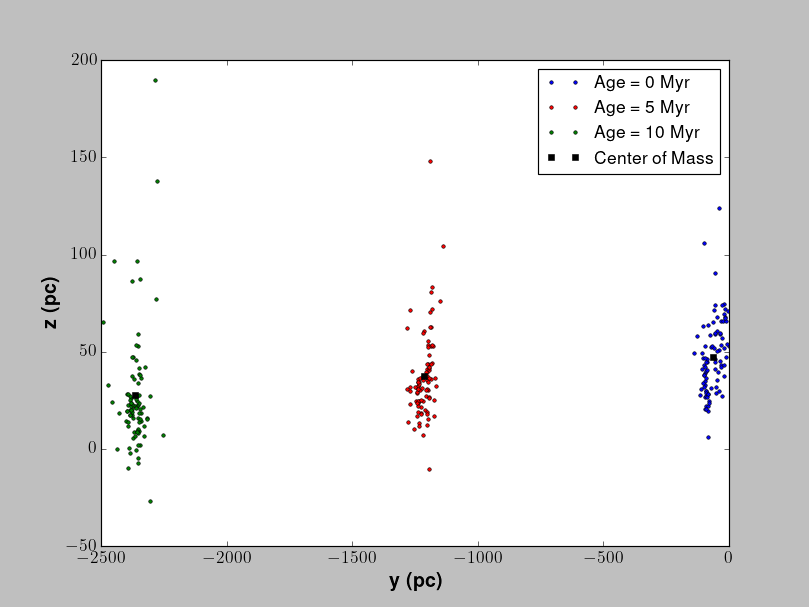

In [ ]:
t = np.linspace(0,10e6,2)

t1 = 0
t2 = 5e6
t3 = 10e6

plt.figure(dpi=70)

plt.xlabel(r'\textbf{y (pc)}', fontsize = 17)
plt.ylabel(r'\textbf{z (pc)}', fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(ya[0]-vy[0]*t1,za[0]-vz[0]*t1,'bo', markersize=3, label = r'Age = %0.0f Myr'%(t1/1e6))
plt.plot(ya[0]-vy[0]*t2,za[0]-vz[0]*t2,'ro', markersize=3, label = r'Age = %0.0f Myr'%(t2/1e6))
plt.plot(ya[0]-vy[0]*t3,za[0]-vz[0]*t3,'go', markersize=3, label = r'Age = %0.0f Myr'%(t3/1e6))

for i in range(1,len(match_clean)):
    
    plt.plot(ya[i]-vy[i]*t1,za[i]-vz[i]*t1,'bo', markersize=3)
    plt.plot(ya[i]-vy[i]*t2,za[i]-vz[i]*t2,'ro', markersize=3)
    plt.plot(ya[i]-vy[i]*t3,za[i]-vz[i]*t3,'go', markersize=3)
    
plt.plot(ycm1,zcm1,'ks', markersize=5, label = 'Center of Mass')
plt.plot(ycm2,zcm2,'ks', markersize=5)
plt.plot(ycm3,zcm3,'ks', markersize=5)

plt.legend(fontsize=15)
plt.savefig('figures/yz.png', dpi=300,bbox_inches='tight')
plt.show()

Una vez con los gráficos de las posiciones, debemos definir una forma de eliminar estrellas outliers que no pertenecen al grupo, para lo cual primero se definirá una función que calcule la distancia media al centro de masa (y en general cada una de las distancias):

In [ ]:
def dist(x0,y0,z0,vx,vy,vz,t):
    
    N = len(x0)
    
    x = x0 - vx*t 
    y = y0 - vy*t
    z = z0 - vz*t
    
    x_cm = x.sum()/N
    y_cm = y.sum()/N
    z_cm = z.sum()/N
    
    r = np.zeros(N)
    
    for i in range(N):
        
        r[i] = d([x[i],y[i],z[i]],[x_cm,y_cm,z_cm])

    return(r,np.mean(r))

# 5. Detección de Outliers.

Una vez con esta función, podemos realizar histogramas de las distancias de las estrellas al centro de masa en diferentes tiempos para detectar outliers, es decir, estrellas que con el paso del tiempo permanecen muy alejadas del centro de masa:

<IPython.core.display.Javascript object>


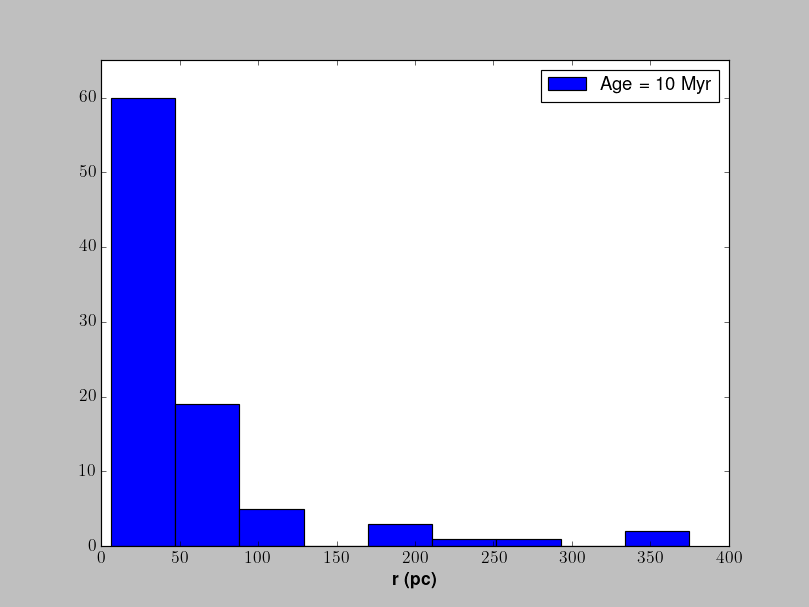

124.79957570118928


In [ ]:
T1 = 1e6
T2 = 5e6
T3 = 10e6

r1 = dist(xa,ya,za,vx,vy,vz,T1)[0]
r2 = dist(xa,ya,za,vx,vy,vz,T2)[0]
r3 = dist(xa,ya,za,vx,vy,vz,T3)[0]

μ1 = np.mean(r1)
μ2 = np.mean(r2)
μ3 = np.mean(r3)

σ1 = np.std(r1)
σ2 = np.std(r2)
σ3 = np.std(r3)

plt.figure(dpi=70)
plt.xlabel(r'\textbf{r (pc)}', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,65)
#plt.hist(r1, bins='rice', edgecolor='k', color = 'r', label = 'Age = %0.0f'%(T1/(1e6))+' Myr')
#plt.hist(r2, bins='rice', edgecolor='k', color = 'b', label = 'Age = %0.0f'%(T2/(1e6))+' Myr')
plt.hist(r3, bins='rice', edgecolor='k', color = 'b', label = 'Age = %0.0f'%(T3/(1e6))+' Myr')
plt.legend(fontsize=16)
plt.savefig('figures/histogram.png', dpi=300,bbox_inches='tight')
plt.show()

print(μ3 + 1*σ3)

Definamos ahora una función que elimine las estrellas que se encuentren fuera del radio de tolerancia:

In [ ]:
def outliers(x0,y0,z0,vx,vy,vz,t,tol):
    
    r = dist(x0,y0,z0,vx,vy,vz,t)[0]
    
    x_new  = x0[r<tol]
    y_new  = y0[r<tol]
    z_new  = z0[r<tol]
    vx_new = vx[r<tol]
    vy_new = vy[r<tol]
    vz_new = vz[r<tol]

    return(x_new,y_new,z_new,vx_new,vy_new,vz_new)

# 6. Edad del Grupo.

Grafiquemos cómo evoluciona la distancia promedio al centro de masa a través del tiempor para diferentes valores del radio de tolerancia:

<IPython.core.display.Javascript object>


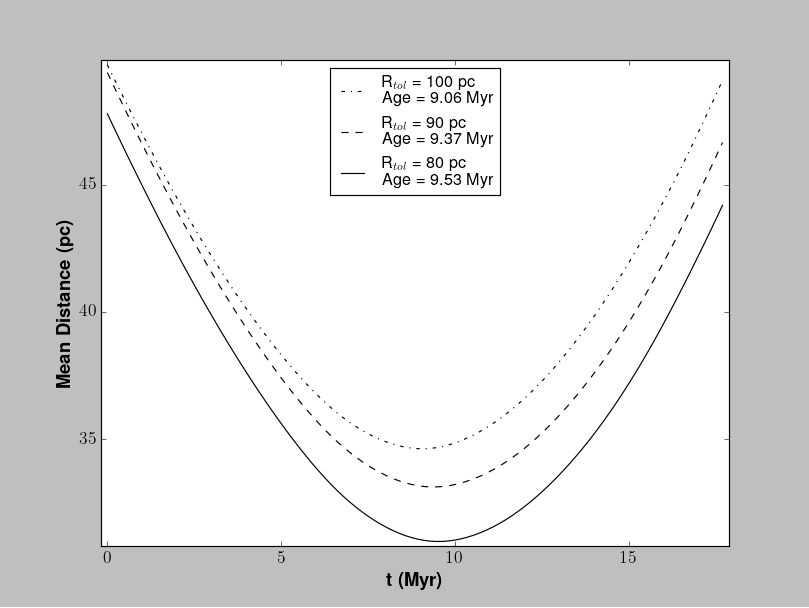

In [ ]:
t = np.linspace(0,17.7e6,100)

tol1 = 100
tol2 = 90
tol3 = 80

s1 = np.array([dist(*outliers(xa,ya,za,vx,vy,vz,10e6,tol1),T)[1] for T in t])
s2 = np.array([dist(*outliers(xa,ya,za,vx,vy,vz,10e6,tol2),T)[1] for T in t])
s3 = np.array([dist(*outliers(xa,ya,za,vx,vy,vz,10e6,tol3),T)[1] for T in t])

func1 = CubicSpline(t/(1e6),s1)
func1p = func1.derivative()

func2 = CubicSpline(t/(1e6),s2)
func2p = func2.derivative()

func3 = CubicSpline(t/(1e6),s3)
func3p = func3.derivative()

age1 = root(func1p,9).x
age2 = root(func2p,9).x
age3 = root(func3p,9).x

plt.figure(dpi=70)
plt.plot(t/(1e6),s1,'-.k',label=r'R$_{tol}$ = %0.0f pc'%tol1 + '\nAge = %0.2f Myr '%age1)
plt.plot(t/(1e6),s2,'--k',label='R$_{tol}$ = %0.0f pc'%tol2 + '\nAge = %0.2f Myr '%age2)
plt.plot(t/(1e6),s3,'-k',label='R$_{tol}$ = %0.0f pc'%tol3 + '\nAge = %0.2f Myr '%age3)
plt.xlabel(r'\textbf{t (Myr)}',fontsize=16)
plt.ylabel(r'\textbf{Mean Distance (pc)}',fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize = 14, loc='upper center')
plt.margins(0.01)
plt.savefig('figures/mean_dist.png', dpi=300,bbox_inches='tight')
plt.show()

Con este gráfico en mente, construyamos una función que calcule la edad del grupo móvil dado un radio de tolerancia:

In [ ]:
def age(tol,τ=10e6):
    
    t = np.linspace(0,17.7e6,100)
    
    s = np.array([dist(*outliers(xa,ya,za,vx,vy,vz,τ,tol),T)[1] for T in t])
    
    func = CubicSpline(t/(1e6),s)
    funcp = func.derivative()
    
    age = root(funcp,9).x
    
    return(age[0])

age(100)

9.064501625436327

Finalmente veamos cómo cambia la distancia promedio $\mu_d$ en función del radio de tolerancia, y calculemos el valor promedio con un intervalo de $\pm \, 2\sigma$:

<IPython.core.display.Javascript object>


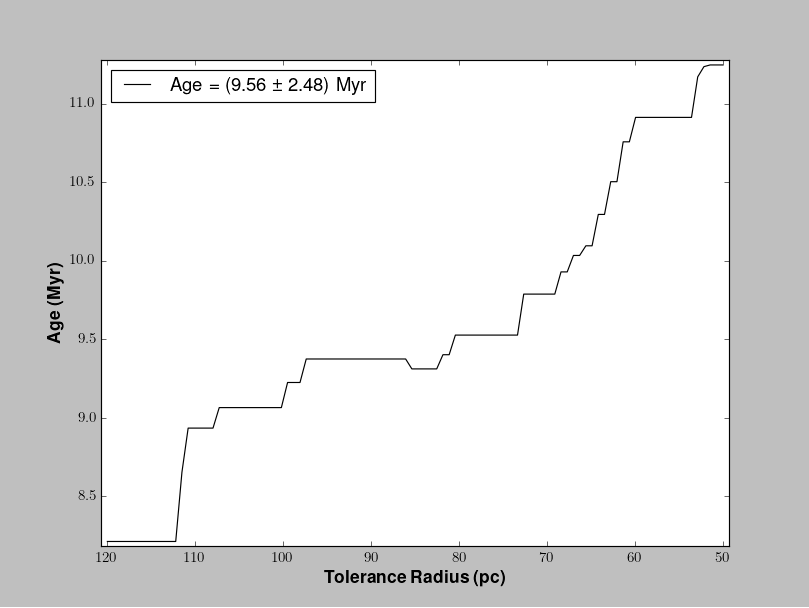

In [ ]:
tol = np.linspace(50,120,100)

τ = 10e6

ages = np.array([age(x,τ) for x in tol])

fig,ax = plt.subplots(dpi=70, figsize =(8,6))
ax.plot(tol,ages,'k-', markersize=3,label='Age = (%0.2f ± %0.2f) Myr'%(np.mean(ages),3*np.std(ages)))
ax.set_xlabel(r'\textbf{Tolerance Radius (pc)}',fontsize=15)
ax.set_ylabel(r'\textbf{Age (Myr)}',fontsize=15)
ax.invert_xaxis()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=16, loc = 2)
plt.margins(0.01)
plt.savefig('figures/age.png', dpi=300,bbox_inches='tight')
plt.show()